In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DATASET.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()




Mounted at /content/drive/


In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import os

tf.__version__

'2.3.0'

# Data Preprocessing

In [26]:
base_dir = '/tmp/DATASET/'

train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

test_datagen = ImageDataGenerator( rescale = 1./255)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=False,
                                   featurewise_center=False,
                                   samplewise_center=False, 
                                   featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False,  
                                   zca_whitening=False)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 16,
                                                    class_mode = 'binary', 
                                                    target_size = (160, 160),
                                                    seed=24,
                                                    color_mode='rgb',
                                                    shuffle=True)

                                                    
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 16,
                                                          class_mode  = 'binary', 
                                                          target_size = (160, 160),
                                                          seed=24,
                                                          color_mode='rgb',
                                                          shuffle=True)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(256, 1280)


# Define a model



In [27]:
INPUT_SHAPE = (160, 160, 3)

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # load weights pretrained on the ImageNet
    include_top=False,  # do not include the ImageNet classifier at the top
    input_shape=INPUT_SHAPE,
    pooling='max'  # add a global max pooling layer after the base model

)
#base_model.summary()


9412608/9406464 [==============================] - 0s 0us/step


In [28]:
from tensorflow.keras import regularizers
base_model.trainable = False

#kernel_regularizer=regularizers.l2(0.001)
def get_model(mods):

    model = tf.keras.Sequential([
            mods,
            Dropout(0.2),
            Dense(512,kernel_regularizer=regularizers.l2(0.001), activation='relu'),
            Dropout(0.2),
            Dense(256, kernel_regularizer=regularizers.l2(0.001),activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid', name='predictions')])

    return model

model = get_model(base_model)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                

# Compiling and training the model

In [30]:
def train_model(model, train_gen, validation_gen, epochs):

    base_learning_rate = 0.0001
    model.compile(optimizer=Adam(
    lr=base_learning_rate),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy'])

    checkpoint = ModelCheckpoint('wastenet.h5', monitor='val_accuracy',save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)                                                 
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=validation_gen, epochs = epochs, verbose=1, callbacks=[earlystopping,checkpoint])

    return history

history = train_model(model, train_generator, validation_generator, epochs=20)

Epoch 1/20
1411/1411 [==============================] - ETA: 0s - loss: 0.8874 - accuracy: 0.8853
Epoch 00001: val_accuracy improved from -inf to 0.84520, saving model to wastenet.h5
1411/1411 [==============================] - 156s 110ms/step - loss: 0.8874 - accuracy: 0.8853 - val_loss: 0.8011 - val_accuracy: 0.8452
Epoch 2/20
1411/1411 [==============================] - ETA: 0s - loss: 0.7426 - accuracy: 0.8897
Epoch 00002: val_accuracy improved from 0.84520 to 0.84918, saving model to wastenet.h5
1411/1411 [==============================] - 152s 108ms/step - loss: 0.7426 - accuracy: 0.8897 - val_loss: 0.7128 - val_accuracy: 0.8492
Epoch 3/20
1411/1411 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.8963
Epoch 00003: val_accuracy improved from 0.84918 to 0.85157, saving model to wastenet.h5
1411/1411 [==============================] - 154s 109ms/step - loss: 0.6758 - accuracy: 0.8963 - val_loss: 0.6629 - val_accuracy: 0.8516
Epoch 4/20
1411/1411 [============

# Plotting the learning curves

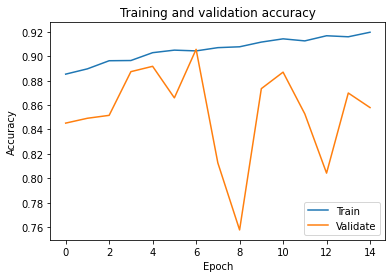

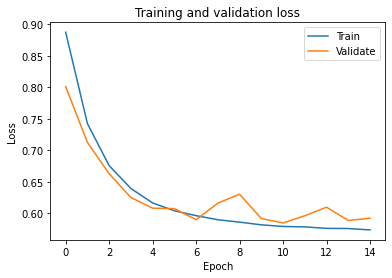

In [31]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validate'], loc='lower right')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validate'], loc='upper right')

# Fine Tuning

In [32]:
base_model.trainable = True

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                

In [33]:
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [34]:
def fine_tuning(model, train_gen, validation_gen, epochs, initial):

    base_learning_rate = 0.0001
    model.compile(optimizer=RMSprop(
    lr=base_learning_rate/20),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy'])
    
    checkpoint = ModelCheckpoint('wastenet_tune.h5', monitor='val_accuracy',save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)                                                 
    earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=validation_gen, epochs = epochs, initial_epoch=initial,verbose=1, callbacks=[earlystopping,checkpoint])
    return history

history = fine_tuning(model, train_generator, validation_generator, epochs=40, initial=history.epoch[-1])

Epoch 15/40
1411/1411 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.8777
Epoch 00015: val_accuracy improved from -inf to 0.90688, saving model to wastenet_tune.h5
1411/1411 [==============================] - 158s 112ms/step - loss: 0.6053 - accuracy: 0.8777 - val_loss: 0.5878 - val_accuracy: 0.9069
Epoch 16/40
1411/1411 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.8896
Epoch 00016: val_accuracy did not improve from 0.90688
1411/1411 [==============================] - 157s 111ms/step - loss: 0.5985 - accuracy: 0.8896 - val_loss: 0.5899 - val_accuracy: 0.8953
Epoch 17/40
1411/1411 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.8957
Epoch 00017: val_accuracy improved from 0.90688 to 0.92439, saving model to wastenet_tune.h5
1411/1411 [==============================] - 157s 112ms/step - loss: 0.5949 - accuracy: 0.8957 - val_loss: 0.5799 - val_accuracy: 0.9244
Epoch 18/40
1411/1411 [==============================]

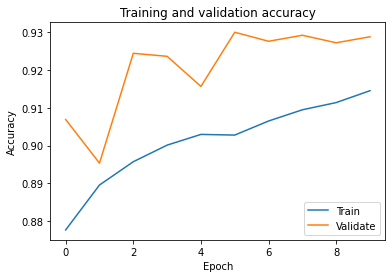

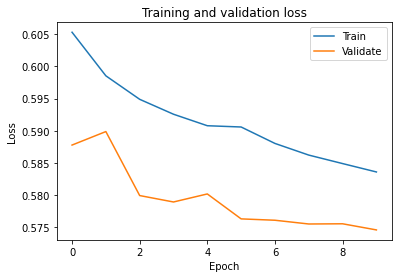

In [35]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validate'], loc='lower right')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validate'], loc='upper right')

# Saving the model

In [ ]:
import pathlib
model = tf.keras.models.load_model('/content/wastenet_tune.h5')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
tflite_model_file = pathlib.Path('/tmp/wastenet.tflite')
tflite_model_file.write_bytes(tflite_model)